In [8]:
from sklearn import svm, metrics
import glob, os.path, re, json

In [9]:
def check_freq(fname):
    
    with open(fname, "r", encoding='utf-8') as f:
        text = f.read()    #일반적으로 readline을 많이 쓰지만, 지금은 줄바꿈의 의미가 없어서 read사용
        text = text.lower()    #전부 소문자로 전환
        
    cnt = [0 for n in range(0,26)] #0부터 25까지를 다 0으로 바꾼 배열을 생성함
    code_a = ord("a") #a = 97
    code_z = ord("z") #z = 122
    
    for ch in text:
        n = ord(ch)
        if code_a <= n <=code_z:    #특수문자, 숫자 등등 필터링(즉, a-z까지만 if문 수행)
            cnt[n-code_a] += 1
    #정규화
    total = sum(cnt)
    freq = list(map(lambda n : n/total, cnt))
    
    name = os.path.basename(fname) #basename: 경로 빼고 파일명만 가져오는 함수
    lang = re.match(r'^[a-z]{2,}',name).group()
    return freq, lang
    
    
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0]) #[0.2333343]
        labels.append(r[1]) #'en'
    return {'freqs': freqs, 'labels' : labels}

##################main
data = load_files('./lang/train/*.txt')
test = load_files('./lang/test/*.txt')

with open("./lang/freq.json",'w',encoding='utf-8') as fp:
    json.dump([data,test],fp)

In [16]:
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])  #학습된 결과는 자동저장 따로 담을필요없음
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
predict

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype='<U2')

In [37]:
clf = svm.SVC()
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [78]:
clf = svm.SVC(C= 1.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10.5,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
clf.fit(data["freqs"], data["labels"])  #학습된 결과는 자동저장 따로 담을필요없음
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
predict

array(['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl'], dtype='<U2')

In [69]:
#결과 테스트하기
ac_score = metrics.accuracy_score(test['labels'],predict)
cl_report = metrics.classification_report(test['labels'],predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

정답률 = 1.0
리포트 =
              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          id       1.00      1.00      1.00         2
          tl       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



precision(예측치 기준): en 0.67 >> en이라고 예측한 것 중에 틀린게 있다..
                        id 1.00 >> 예측결과로 나온 id는 다 맞춤
recall(실측치 기준): id 0.50 >> 실제 id 중에 50%만 id라 맞춤

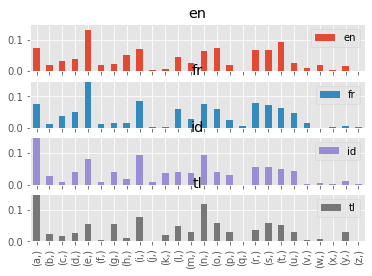

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import json
# 알파벳 출현 빈도 데이터 읽어 들이기 --- (※1)
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)
# 언어마다 계산하기 --- (※2)
lang_dic = {}
for i, lbl in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2
# Pandas의 DataFrame에 데이터 넣기 --- (※3)
asclist = [[chr(n) for n in range(97,97+26)]]
df = pd.DataFrame(lang_dic, index=asclist)
# 그래프 그리기 --- (※4)
plt.style.use('ggplot')
df.plot(kind="bar", subplots=True, ylim=(0,0.15))
plt.savefig("lang-plot.png")

In [85]:
from sklearn import svm 
from sklearn.externals import joblib
import json
# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0]
# 데이터 학습하기
clf = svm.SVC(C=1.5,gamma=10.5)
clf.fit(data["freqs"], data["labels"])
# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")  #pickle 저장할 땐, joblib사용
print("ok")

ok


In [92]:
#joblib.load("./lang/freq.pkl")

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)